# Using NZRA Data as Targets

We have refined the AI task to better reflect how the model will be used at inference time. The task is as follows:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

This is the first experiment which we are developing & running on the NIWA HPC.

## Experiment Setup
- do imports
- set up project wide settings & variables

In [1]:
%load_ext autoreload

In [2]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.logging_config import setup_logging
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import TEMPERATURE, PRECIPITATION, SURFACE_PRESSURE, HUMIDITY, WIND_SPEED, WIND_DIRECTION, WIND_U, WIND_V, VERTICAL_VELOCITY, GEOPOTENTIAL, SUN_CULMINATION, SUN_ANGLE, SEA_SURFACE_TEMPERATURE, TEMPERATURE_MIN, TEMPERATURE_MAX, SHORTWAVE_FLUX_DOWN, BAND_3, BAND_9, BAND_13, ELEVATION, TOPOGRAPHIC_POSITION_INDEX, LAND_SEA_MASK
from convcnp_assim_nz.utils.variables.coord_names import LATITUDE, LONGITUDE, TIME
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position
from convcnp_assim_nz.learning.model_training import train_epoch_pickled, compute_val_loss_pickled, return_sample_predictions

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [3]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import deepsensor.torch
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from mpl_toolkits.basemap import Basemap
import pickle
import logging
from datetime import datetime
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds
from deepsensor.data.utils import compute_xarray_data_resolution, compute_pandas_data_resolution


In [4]:
# setup logging
setup_logging()  # configure logging
logger = logging.getLogger(__name__)
logger.info("Notebook execution started.")

# these are only used when the environment variables are not set - i.e. when debugging on a jupyter kernel
DEV_DEFAULT = "1"
DATASET_GEN_DEFAULT = "0"

# settings: development mode and dataset generation mode
dev = True if os.getenv("DEVELOPMENT_ENVIRONMENT", DEV_DEFAULT) == "1" else False
dataset_generation = True if os.getenv("DATASET_GENERATION", DATASET_GEN_DEFAULT) == "1" else False

# CUDA & filepath setup
logger.info(f"CUDA available: {torch.cuda.is_available()}")
if not os.environ["HOSTNAME"] in ['hub-worker01', 'hub-worker02', 'login01.slv.hpc.niwa.co.nz'] and not dataset_generation: # no GPU available on jupyter node. Dataset generation always on CPU
    set_gpu_default_device()

use_absolute_filepaths(True)

# setup tensorboard
TB_BASE = "/home/crowelenn/dev/convcnp-assim-nz"
TB_EXPERIMENT = "experiment4"

if dev:
    TB_PREFIX = "debug_runs"
else:
    TB_PREFIX = "runs"

EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME", "default_experiment")

# tensorboard tags
TB_TRAIN_LOSS = "Loss/Train"
TB_VAL_LOSS = "Loss/Validation"
TB_RUN_LOGS = "Run/Steps"
TB_EXAMPLE_TASK = "Tasks/Example"
TB_CUDA_MEM = "System/CUDA_Memory_MB"
TB_PREDICTIONS_TRAIN_PLOT = "Predictions/Train"
TB_PREDICTIONS_VAL_PLOT = "Predictions/Validation"
TB_LEARNING_RATE = "Hyperparameters/Learning_Rate"

if not dev:
    tb_path = os.path.join(TB_BASE, ".tensorboard", TB_EXPERIMENT, TB_PREFIX, f"run_{datetime.now().strftime('%d-%m-%YT%H:%M:%S')}")

    tb_writer = SummaryWriter(log_dir=tb_path)

2026-01-30 00:16:29 - INFO - __main__ - Notebook execution started.
2026-01-30 00:16:29 - INFO - __main__ - CUDA available: False


### Hyperparameters

In [ ]:
# DATASET HYPERPARAMETERS

# variables for this experiment. 2017 will be saved for testing
years = [2013, 2014, 2015, 2016] # this gets modified later if PROCESS_YEAR is set
all_years = years.copy() # this needs to be kept

target_variable = TEMPERATURE

# if the target variable is not a list, make it one
if not isinstance(target_variable, list):
    target_variable = [target_variable]

# exclude the first and last day of each year - occasionally have incomplete data on these days
# this is minimal data loss and avoids issues with incomplete data
time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{max(years)}-12-30T23:00:00')

# you can set PROCESS_YEAR when running this notebook to only process a single year
# this allows parallelising dataset generation across multiple notebook runs
process_year = 2013
if os.getenv("PROCESS_YEAR") is not None and int(os.getenv("PROCESS_YEAR")) in years:
    process_year = int(os.getenv("PROCESS_YEAR"))
    years = [process_year]
    time_slice = slice(f'{process_year}-01-02T00:00:00', f'{process_year}-12-30T23:00:00')

if min(years) < 2017:
    load_himawari = False
else:
    load_himawari = True

TOPO_COARSEN = 2
H8_COARSEN = 2

NORM_SIZE = 1000
TRAIN_SPLIT = 0.5

# LEARNING HYPERPARAMETERS
N_EPOCHS = 75
LR = 5e-5
BATCH_SIZE = 16
VAL_EVERY = 5
CHECKPOINT_EVERY = 50
UNET_CHANNELS = (32, 64, 128, 256, 512)
INTERNAL_DENSITY = 1111 // 2 # reduced from 1997 (from stations resolution)
INITIAL_NOISE = 5e-2
UNFIX_NOISE_AT_EPOCH = 0
TARGET_SAMPLING_COUNT = 10000 # not used when SAMPLING_STRATEGY is "all"
SAMPLING_STRATEGY = "sample" # this overrides TARGET_SAMPLING_COUNT, and just samples all points

USE_GRAD_CLIP = False
GRAD_CLIP_VALUE = 1.0
EFFECTIVE_BATCH_SIZE = 32
GRAD_ACCUM_STEPS = EFFECTIVE_BATCH_SIZE // BATCH_SIZE

# override some hyperparameters for dev environment
if dev:
    years = [2013]

    time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{max(years)}-01-30T23:00:00')
    SAMPLING_STRATEGY = "sample"
    NORM_SIZE = 100 # smaller norm size for dev

    N_EPOCHS = 2
    VAL_EVERY = 1

    INTERNAL_DENSITY = 1111
    INITIAL_NOISE = 5e-2
    UNFIX_NOISE_AT_EPOCH = 0

In [6]:
# Logging

if not dev:
    tb_writer.add_text(TB_RUN_LOGS, f'Experiment 4 started {"in dataset generation mode" if dataset_generation else "without dataset generation"} {"in development mode." if dev else "in production mode."}', 0)
    tb_writer.flush()

if dataset_generation:
    logger.info("Data Preprocessing started. This notebook will run in dataset generation mode.")
else:
    logger.info("Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.")

if dev:
    logger.warning("Running in development mode with reduced dataset sizes and increased coarsening.")

2026-01-30 00:16:36 - INFO - __main__ - Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.
2026-01-30 00:16:36 - WARNING - __main__ - Running in development mode with reduced dataset sizes and increased coarsening.


## Preprocess the datasets

In [7]:
# load datasets

# data processors
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
station_processor = ProcessStations(mode="csv")

if load_himawari:
    h8_processor = ProcessHimawari8()

# load datasets
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)

if load_himawari:
    h8_ds = h8_processor.load_ds(years=years)

if TEMPERATURE in target_variable:
    csv_file = '2013-2018_temps.csv'
if WIND_U in target_variable or WIND_V in target_variable:
    csv_file = '2013-2018_winds.csv'
# solar radiation not supported yet, but the SR file is: 2013-2018_radiation.csv

stations_df = station_processor.load_df(target_variable, csv_file=csv_file, year_start=min(years), year_end=max(years))

# filter datasets to time slice
nzra_ds = nzra_ds.sel(time=time_slice)
era5_ds = era5_ds.sel(time=time_slice)

if load_himawari:
    h8_ds = h8_ds.sel(time=time_slice)

logger.info("Lazy-loaded datasets successfully.")

2026-01-30 00:16:39 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:16:40 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:16:41 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:16:57 - INFO - __main__ - Lazy-loaded datasets successfully.


Loaded CSV with length 13822573
Loaded CSV with length 2193495


In [8]:
# Datasets need to be resampled to hourly frequency, + de-duplicated

nzra_ds = nzra_ds.sel(time=time_slice).chunk({"time": 24})
era5_ds = era5_ds.sel(time=time_slice).chunk({"time": 24})

target_time = nzra_ds.time.resample(time="1h").first()

nzra_ds = nzra_ds.reindex(time=target_time, method="nearest", tolerance="5min")
era5_ds = era5_ds.reindex(time=target_time, method="nearest", tolerance="5min")

logger.info("Datasets resampled to hourly frequency.")

# himarwari resampling hasn't been tested yet - commenting out for now
#if load_himawari:
#    h8_ds = h8_ds.resample(time='1h').nearest(tolerance="30min")
#    h8_ds = h8_ds.sel(time=time_slice)

target_time_pd = pd.to_datetime(target_time.values)
stations_df = stations_df[
    (stations_df['time'] >= target_time_pd.min()) &
    (stations_df['time'] <= target_time_pd.max())
]

logger.info("Station data filtered to match NZRA time range.")    

logger.info(f"NZRA: {len(nzra_ds['time'])}, ERA5: {len(era5_ds['time'])}, Stations: {len(np.unique(stations_df['time'].values))}")

2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:00 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:01 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-30 00:17:01 - INFO - fsspe

#### Pre-process the stations data (pandas)

In [9]:
# preprocess the stations
stations_df = stations_df[target_variable + [LATITUDE, LONGITUDE, TIME]]

stations_reset = stations_df.reset_index()
stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[target_variable]
stations_resample = stations_resample.reset_index().set_index([TIME, LATITUDE, LONGITUDE]).sort_index()

# resample stations to times in NZRA
target_time_pd = pd.to_datetime(target_time.values) 
stations_resample = stations_resample[stations_resample.index.get_level_values('time').isin(target_time_pd)]

# crop the stations to NZ bounds
crop_bottom = nzra_ds.lat.min().item()
crop_top = nzra_ds.lat.max().item()
crop_left = nzra_ds.lon.min().item()
crop_right = nzra_ds.lon.max().item()

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

logger.info("Station Preprocessing complete.")

/var/tmp/pbs.1591948.pbsserver01/ipykernel_740149/3224810285.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[target_variable]
2026-01-30 00:17:15 - INFO - __main__ - Station Preprocessing complete.


#### Pre-process NZRA data

In [10]:
# preprocess NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

nzra_ds = nzra_ds[target_variable]

if not nzra_ds.indexes['time'].is_unique:
    nzra_ds = nzra_ds.drop_duplicates(dim='time')
    logger.info("Dropping duplicate times from NZRA dataset.")

logger.info("NZRA Preprocessing complete.")

2026-01-30 00:17:17 - INFO - __main__ - NZRA Preprocessing complete.


#### Pre-process Himawari 8 data

In [11]:
# preprocess H8
if load_himawari:
    h8_ds = h8_ds[[BAND_3, BAND_9, BAND_13]]

    h8_ds = h8_ds.coarsen(lat=H8_COARSEN, lon=H8_COARSEN, boundary="trim").mean()

    logger.info("Himawari-8 Preprocessing complete.")

#### Pre-process ERA5 Data

In [12]:
# preprocess ERA5
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# convert temperature from K to C
if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

# add sun angle and culmination to ERA5 dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

if not era5_ds.indexes['time'].is_unique:
    era5_ds = era5_ds.drop_duplicates(dim='time')
    logger.info("Dropping duplicate times from ERA5 dataset.")

logger.info("ERA5 Preprocessing complete.")

2026-01-30 00:17:22 - INFO - __main__ - ERA5 Preprocessing complete.


#### Pre-process Auxilliary Data (topography)

In [13]:
# preprocess auxiliary dataset (topography, tpi, land/sea mask)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])
ds_aux = ds_aux.reindex({LATITUDE: nzra_ds[LATITUDE], LONGITUDE: nzra_ds[LONGITUDE]}, method='nearest') # expand to the NZRA grid

ds_aux[LAND_SEA_MASK] = ds_aux[ELEVATION].where(ds_aux[ELEVATION].isnull(), 1, 0).fillna(0)

ds_aux_coarse  = ds_aux.coarsen(
    lat=TOPO_COARSEN, 
    lon=TOPO_COARSEN, 
    boundary='trim').mean()

ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

logger.info("Auxiliary Preprocessing complete.")

2026-01-30 00:18:17 - INFO - __main__ - Auxiliary Preprocessing complete.


#### Crop datasets to matching square bounds

In [14]:
# crop all datasets to a square bound of lat -32.5, -47.5 and lon 165, 180
crop_bottom = -47.5
crop_top = -32.5
crop_left = 165.0
crop_right = 180.0

nzra_ds = nzra_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
era5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
ds_aux = ds_aux.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
ds_aux_coarse = ds_aux_coarse.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

if load_himawari:
    h8_ds = h8_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

logger.info("Datasets cropped to NZ region.")

2026-01-30 00:19:13 - INFO - __main__ - Datasets cropped to NZ region.


In [15]:
logger.info("Dataset preprocessing completed.")
if not dev:
    tb_writer.add_text(TB_RUN_LOGS, "Dataset preprocessing completed.", 1)
    tb_writer.flush()

2026-01-30 00:19:15 - INFO - __main__ - Dataset preprocessing completed.


## Visualise data sources

This may be removed eventually...

#### Himawari 8

Visualise the himawari8 dataset in bands 3, 9, and 13. Each band provides different information about clouds in the atmosphere.

This will be assimilated into the ERA5 data

In [16]:
if load_himawari:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    h8_ds.isel(time=1)[BAND_3].plot(ax=ax[0])
    h8_ds.isel(time=1)[BAND_9].plot(ax=ax[1])
    h8_ds.isel(time=1)[BAND_13].plot(ax=ax[2])

    plt.tight_layout()

#### NZRA
Visualise temperature from the NZRA dataset.

This will be sampled from and used as the target set.

For initial experiments, the target is 'temperature' but will be updated as use-cases require.

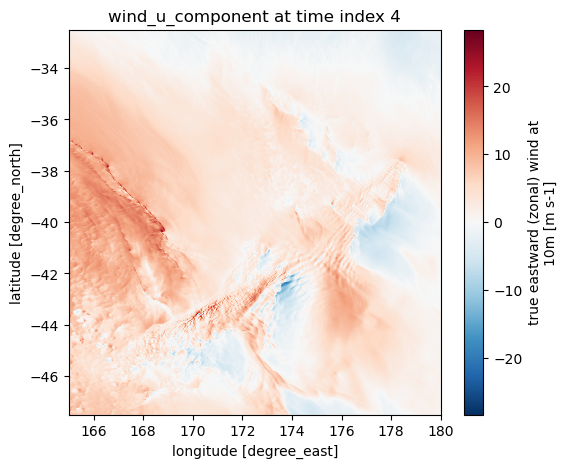

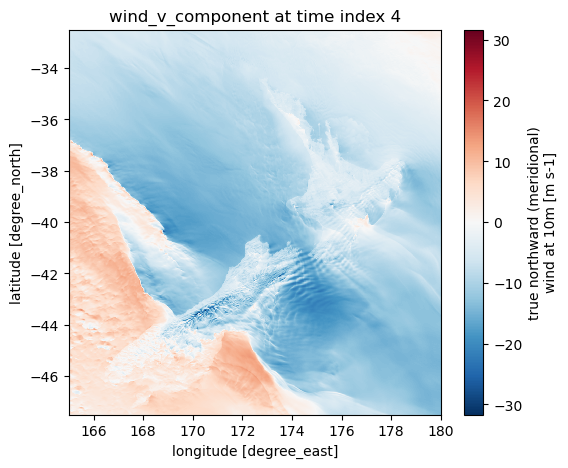

In [17]:
for var in target_variable:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    nzra_ds[var].isel(time=4).plot(ax=ax)
    plt.title(f"{var} at time index 4")
    plt.show()

#### Auxiliary
Elevation, TPI, and land/sea mask.

This is auxiliary - i.e. constant across time.

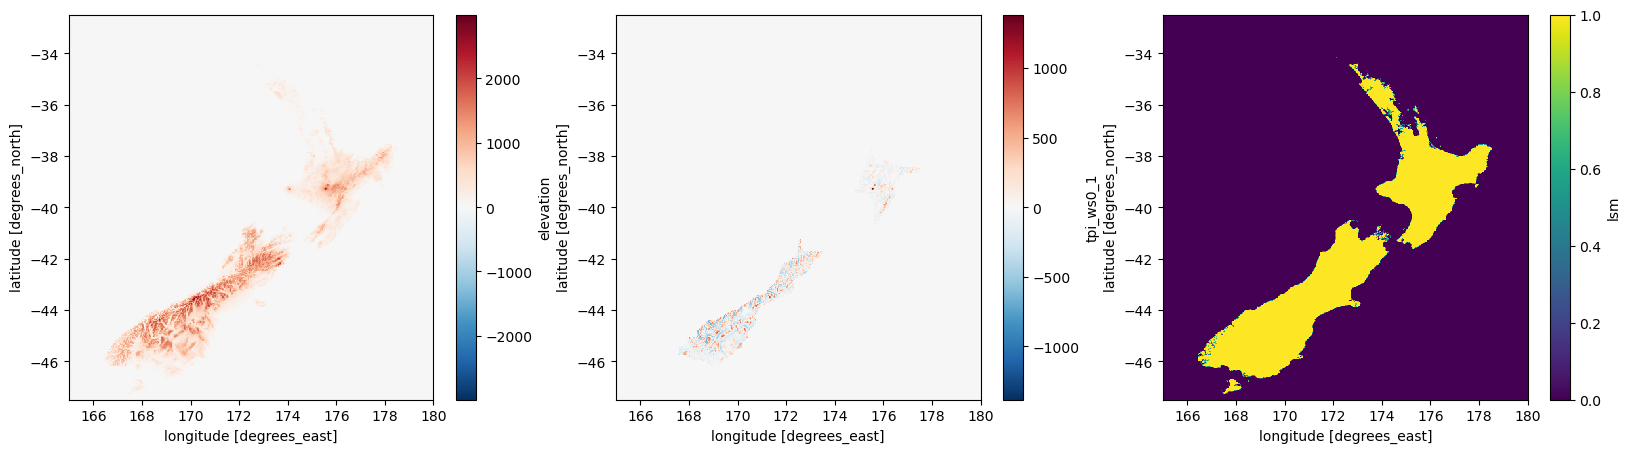

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ds_aux_coarse[ELEVATION].plot(ax=ax[0])
ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[1])
ds_aux_coarse[LAND_SEA_MASK].plot(ax=ax[2])

#### ERA5
The following six variables together form a closed description of the atmosphere. We may include all these variables in the model.

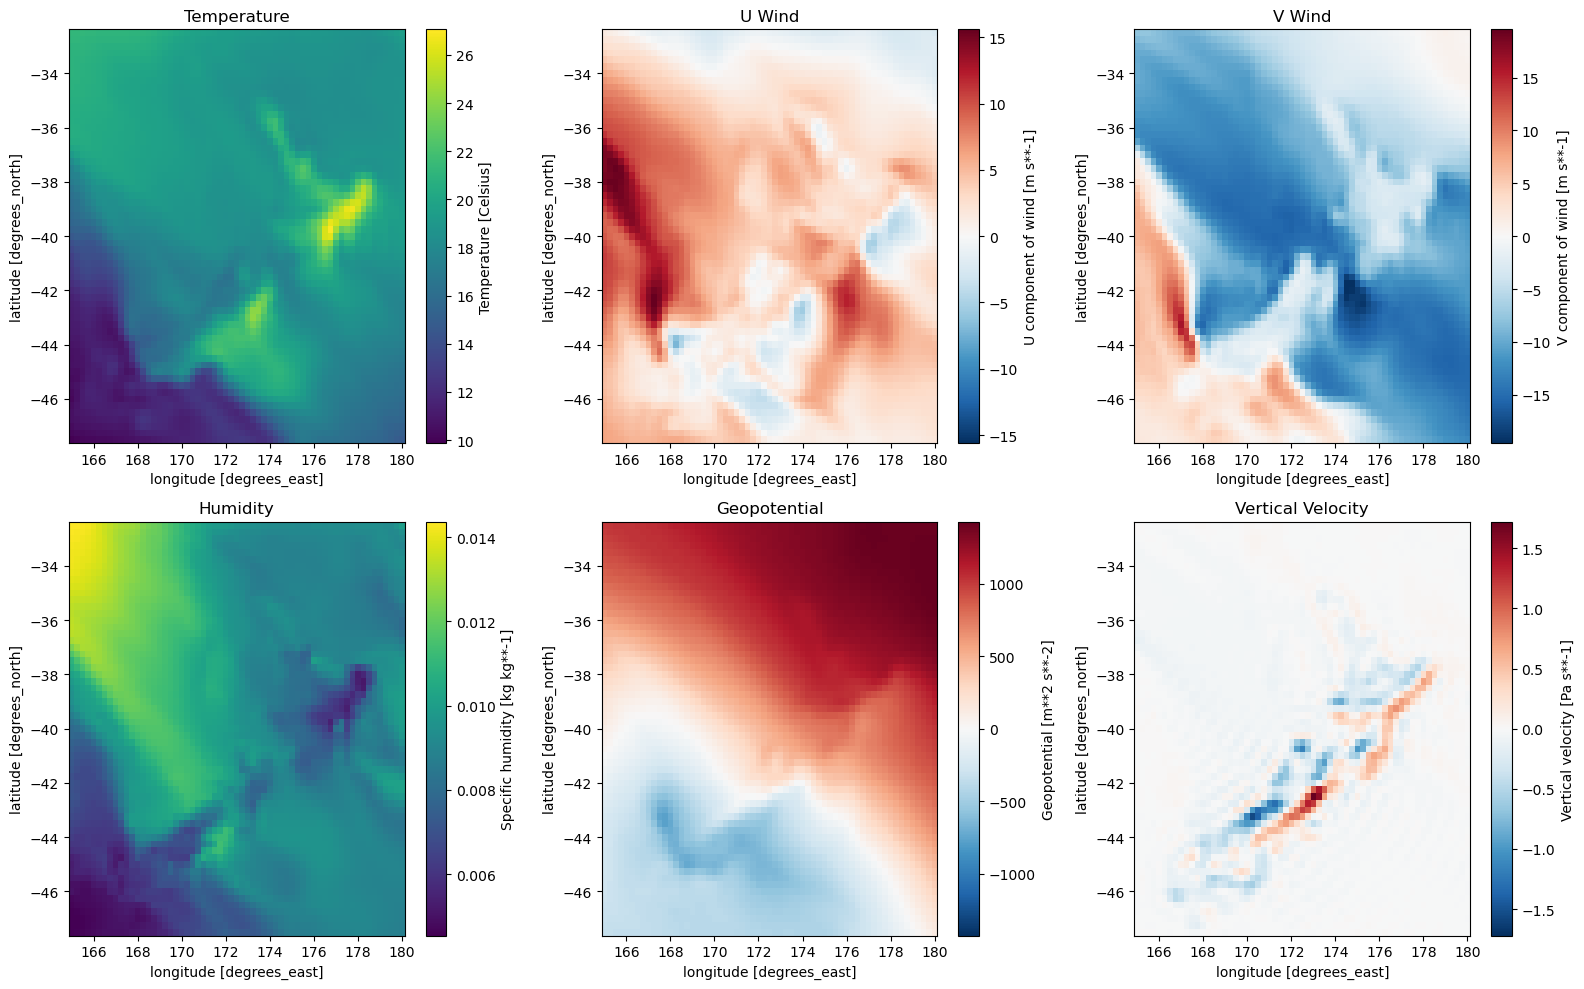

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

era5_ds[TEMPERATURE].isel(time=3).plot(ax=ax[0, 0])
ax[0, 0].set_title("Temperature")

era5_ds[WIND_U].isel(time=3).plot(ax=ax[0, 1])
ax[0, 1].set_title("U Wind")

era5_ds[WIND_V].isel(time=3).plot(ax=ax[0, 2])
ax[0, 2].set_title("V Wind")

era5_ds[HUMIDITY].isel(time=3).plot(ax=ax[1, 0])
ax[1, 0].set_title("Humidity")

era5_ds[GEOPOTENTIAL].isel(time=3).plot(ax=ax[1, 1])
ax[1, 1].set_title("Geopotential")

era5_ds[VERTICAL_VELOCITY].isel(time=3).plot(ax=ax[1, 2])
ax[1, 2].set_title("Vertical Velocity")
plt.tight_layout()

#### ERA5 Sun Position Annotations

The sun culmination and sun angle have been added as extra channels to ERA5 to encode time of year and time of day respectively.

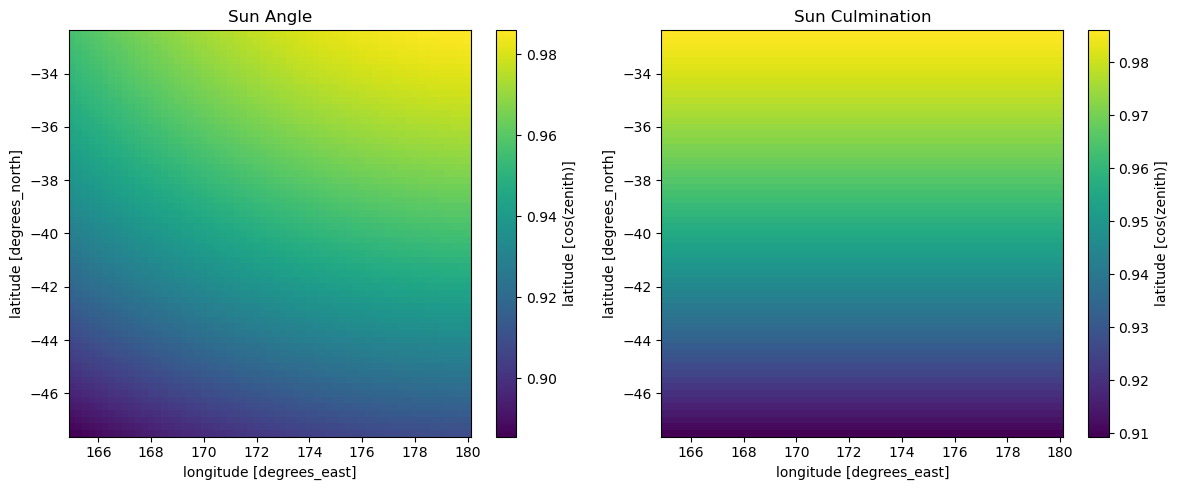

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

era5_ds[SUN_ANGLE].isel(time=0).plot(ax=ax[0])
ax[0].set_title("Sun Angle")

era5_ds[SUN_CULMINATION].isel(time=0).plot(ax=ax[1])
ax[1].set_title("Sun Culmination")

plt.tight_layout()

#### Ground Stations

A subset (and arbitrary number) of ground stations will be used as off-grid inputs to the model.

A set of stations can also be used as supplementary target points to NZRA - letting the model learn at spaces off the NZRA grid, and theoretically allowing the model to learn outputs which could be "more correct" than NZRA - provided the stations haven't been assimilated into NZRA.

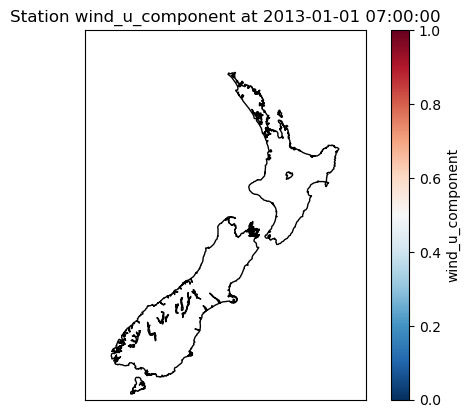

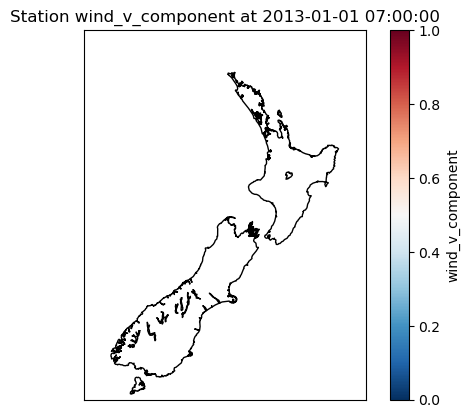

In [21]:
for var in target_variable:
    time_step = "2013-01-01 07:00:00"
    m = Basemap(projection='merc', llcrnrlat=nzra_ds[LATITUDE].min().item(), urcrnrlat=nzra_ds[LATITUDE].max().item(), llcrnrlon=nzra_ds[LONGITUDE].min().item(), urcrnrlon=nzra_ds[LONGITUDE].max().item(), resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
            stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
    sc = m.scatter(x, y,
                c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step][var].values,
                cmap='RdBu_r', marker='o', edgecolor='k', s=100)
    plt.colorbar(sc, label=f'{var}')
    plt.title(f'Station {var} at {time_step}')
    plt.show()

## Final Filtering of datasets

This will vary by experiment.

In [ ]:
# only select temperature + sun position from ERA5
era5_ds = era5_ds[[TEMPERATURE, SUN_ANGLE, SUN_CULMINATION]]

# only select topography + lsm from auxiliary
ds_aux = ds_aux[[ELEVATION, LAND_SEA_MASK]]
ds_aux_coarse = ds_aux_coarse[[ELEVATION, LAND_SEA_MASK]]

## Deepsensor Dataset Generation

The data needs to be converted from xarray datasets/csv's into deepsensor tasks.

To reiterate the dataset structure:
This varies by experiment so is indicative only

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

In [23]:
# create dataset/model directories

dataset_pickle_path = get_env_var('DATASET_PICKLE_PATH')
models_path = get_env_var('MODEL_DIR')

train_suffix = 'experiment4_nzra_target_train_tasks'
val_suffix = 'experiment4_nzra_target_val_tasks'

train_dir = os.path.join(dataset_pickle_path, train_suffix)
val_dir = os.path.join(dataset_pickle_path, val_suffix)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# create model directories
model_dir = os.path.join(models_path, EXPERIMENT_NAME)
checkpoint_dir = os.path.join(model_dir, 'checkpoints')
norm_dir = os.path.join(model_dir, 'norm_params')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(norm_dir, exist_ok=True)

A model is required to generate tasks. A model needs a task loader, and a task loader needs processed dataframes. The first time this notebook runs, a data_processor is saved to `norm_dir`. In future runs, the notebook attempts to load a saved data processor from the `norm_dir`, to avoid data leakage. The initial data_processor is created with a sample of 1000 tasks.

In [24]:
save_data_processor = True

try:
    data_processor = DataProcessor(norm_dir)
    logger.info(f"Loaded existing normalization parameters: {data_processor}")
    save_data_processor = False # this stops the data processor from being saved again later
except:
    data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
    logger.info("Created new DataProcessor and will compute normalization parameters.")

2026-01-30 00:20:01 - INFO - __main__ - Created new DataProcessor and will compute normalization parameters.


Processing all the datasets at once (before task generation) leads to an OOM error, and a subsequent kernel crash. Instead, we are going to fit the data_processor to a subset of the training data (to estimate normalisation parameters) and then generate the processed sets for dates individually at task generation time.

In [25]:
# determine the training and validation date ranges

date_vals = np.unique(stations_resample.index.get_level_values('time').values)

train_pct = int(len(date_vals) * TRAIN_SPLIT)
valid_pct = len(date_vals) - train_pct

train_datetimes = date_vals[:train_pct]
val_datetimes   = date_vals[train_pct:]

# select n random training time steps for normalisation parameter estimation
norm_datetimes = np.random.choice(np.array(train_datetimes), size=min(NORM_SIZE, len(train_datetimes)), replace=False)

era5_estimator_ds = era5_ds.sel(time=norm_datetimes)
nzra_estimator_ds = nzra_ds.sel(time=norm_datetimes)
stations_estimator_df = stations_resample.loc[stations_resample.index.get_level_values('time').isin(norm_datetimes)]

if load_himawari:
    h8_estimator_ds = h8_ds.sel(time=norm_datetimes)

In [26]:
# auxially datasets can be generated in advance, as they don't have a time dependency
era5_processed_estimator_ds, nzra_processed_estimator_ds, stations_processed_estimator_df = data_processor([era5_estimator_ds, nzra_estimator_ds, stations_estimator_df])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

In [27]:
# himawari8 has been temporarily excluded

norm_task_loader = TaskLoader(
            context = [stations_processed_estimator_df, era5_processed_estimator_ds, ds_aux_coarse_processed], 
            target = nzra_processed_estimator_ds,
            aux_at_targets = ds_aux_processed)

In [ ]:
model = ConvNP(data_processor, 
               norm_task_loader, 
               unet_channels=UNET_CHANNELS, 
               likelihood="gnp", 
               internal_density=INTERNAL_DENSITY,
               conv_arch="unet-res",
               aux_t_mlp_layers=(128, 256, 128),
               unet_kernels=7)

dim_yc inferred from TaskLoader: (2, 4, 4)
dim_yt inferred from TaskLoader: 2
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.00045004500450045, 0.00833333283662796, 0.0008999999845400453]
decoder_scale inferred from TaskLoader: 0.0009000900090009


In [29]:
print(f"ERA5 Resolution: {1/compute_xarray_data_resolution(era5_processed_estimator_ds)}")
#print(f"H8 Resolution: {1/compute_xarray_data_resolution(h8_processed_estimator_ds)}")
print(f"NZRA Resolution: {1/compute_xarray_data_resolution(nzra_processed_estimator_ds)}")
print(f"Auxiliary Resolution: {1/compute_xarray_data_resolution(ds_aux_processed)}")
print(f"Stations Resolution: {1/compute_pandas_data_resolution(stations_processed_estimator_df)}")

ERA5 Resolution: 60.0000035762789
NZRA Resolution: 1111.1111111111122
Auxiliary Resolution: 1111.1111111111122
Stations Resolution: 7894.299496910273


Hence using 1111 for the model internal density.

In [ ]:
#import cartopy
#import cartopy.crs as ccrs
#import cartopy.feature as cf

#cartopy.config['data_dir'] = get_env_var("CARTOPY_FILES_DIR")

#fig = deepsensor.plot.receptive_field(model.model.receptive_field, data_processor, ccrs.PlateCarree(), (165, 180, -47.5, -32.5))

: 

: 

: 

In [31]:
logger.info("Training and validation datetime splits created. Setting up dataset pickle file paths.")

2026-01-28 23:09:57 - INFO - __main__ - Training and validation datetime splits created. Setting up dataset pickle file paths.


In [32]:
if (not dev) and save_data_processor:
    data_processor.save(norm_dir)

In [33]:
def generate_and_save_tasks(
    datetimes,
    era5_ds,
    nzra_ds,
    stations_resample,
    data_processor,
    task_dir,
    ds_aux_coarse_processed,
    ds_aux_processed,
    logger,
    tasks_len,
    split_name,
    *,
    h8_ds=None,
    load_himawari=False,
    process_year=None,
    all_years=None,
):
    # Generate Deepsensor tasks for a given split and save them to disk.

    logger.info(f"Generating {split_name} Deepsensor tasks.")

    for i, date in enumerate(datetimes):
        # Select data for this timestep
        era5_date_ds = era5_ds.sel(time=date)
        nzra_date_ds = nzra_ds.sel(time=date)
        stations_date_df = stations_resample.loc[
            stations_resample.index.get_level_values("time") == date
        ]

        if load_himawari:
            _ = h8_ds.sel(time=date)  # kept for future use

        # Process data
        era5_proc, nzra_proc, stations_proc = data_processor(
            [era5_date_ds, nzra_date_ds, stations_date_df]
        )

        # Build task loader
        task_loader = TaskLoader(
            context=[stations_proc, era5_proc, ds_aux_coarse_processed],
            target=nzra_proc,
            aux_at_targets=ds_aux_processed,
        )

        # File path logic
        if process_year is not None:
            base_idx = all_years.index(process_year) * (366 - 2) * 24
            filename = f"{base_idx + i}_0.pkl"
        else:
            filename = f"{i}_0.pkl"

        path = os.path.join(task_dir, filename)

        # Create and save task
        task = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling=["all"],
        )

        with open(path, "wb") as f:
            pickle.dump(task, f)

        if i % 10 == 0:
            logger.info(
                f"dataset generation progress: {i}/{tasks_len} {split_name} tasks completed."
            )

    logger.info(f"{split_name.capitalize()} Deepsensor task dataset generation completed.")

In [37]:
# compute lengths for logging
train_tasks_len = len(train_datetimes)
val_tasks_len = len(val_datetimes)

logger.info(f"Train dataset: {len(train_datetimes)}.")
logger.info(f"Validation dataset: {len(val_datetimes)}.")
logger.info("Dataset generation beginning.")

# you can disable dataset generation by setting the DATASET_GENERATION env var to "0"
if dataset_generation:
    logger.info("Generating and saving Deepsensor tasks to disk.")

    # generate train tasks
    generate_and_save_tasks(
        datetimes=train_datetimes,
        era5_ds=era5_ds,
        nzra_ds=nzra_ds,
        stations_resample=stations_resample,
        data_processor=data_processor,
        task_dir=train_dir,
        ds_aux_coarse_processed=ds_aux_coarse_processed,
        ds_aux_processed=ds_aux_processed,
        logger=logger,
        tasks_len=train_tasks_len,
        split_name="train",
        load_himawari=load_himawari,
        process_year=process_year,
        all_years=all_years,
    )

    # generate validation tasks
    generate_and_save_tasks(
        datetimes=val_datetimes,
        era5_ds=era5_ds,
        nzra_ds=nzra_ds,
        stations_resample=stations_resample,
        data_processor=data_processor,
        task_dir=val_dir,
        ds_aux_coarse_processed=ds_aux_coarse_processed,
        ds_aux_processed=ds_aux_processed,
        logger=logger,
        tasks_len=val_tasks_len,
        split_name="val",
        process_year=process_year,
        all_years=all_years,
    )

    logger.info("Deepsensor task dataset generation completed.")
    if not dev:
        tb_writer.add_text(
            TB_RUN_LOGS,
            "Deepsensor task dataset generation completed.",
            2,
        )
else:
    if not dev:
        tb_writer.add_text(TB_RUN_LOGS, "Deepsensor task dataset generation skipped.", 2)

2026-01-28 23:12:16 - INFO - __main__ - Train dataset: 348.
2026-01-28 23:12:16 - INFO - __main__ - Validation dataset: 348.
2026-01-28 23:12:16 - INFO - __main__ - Dataset generation beginning.


2026-01-28 23:12:16 - INFO - __main__ - Generating and saving Deepsensor tasks to disk.
2026-01-28 23:12:16 - INFO - __main__ - Generating train Deepsensor tasks.
2026-01-28 23:12:19 - INFO - __main__ - dataset generation progress: 0/348 train tasks completed.
2026-01-28 23:12:29 - INFO - __main__ - dataset generation progress: 10/348 train tasks completed.


KeyboardInterrupt: 

In [34]:
if SAMPLING_STRATEGY == "all":
    task_to_plot = norm_task_loader(norm_datetimes[0], context_sampling=["all", "all", "all"], target_sampling=["all"])
else:
    task_to_plot = norm_task_loader(norm_datetimes[0], context_sampling=["all", "all", "all"], target_sampling=[TARGET_SAMPLING_COUNT])

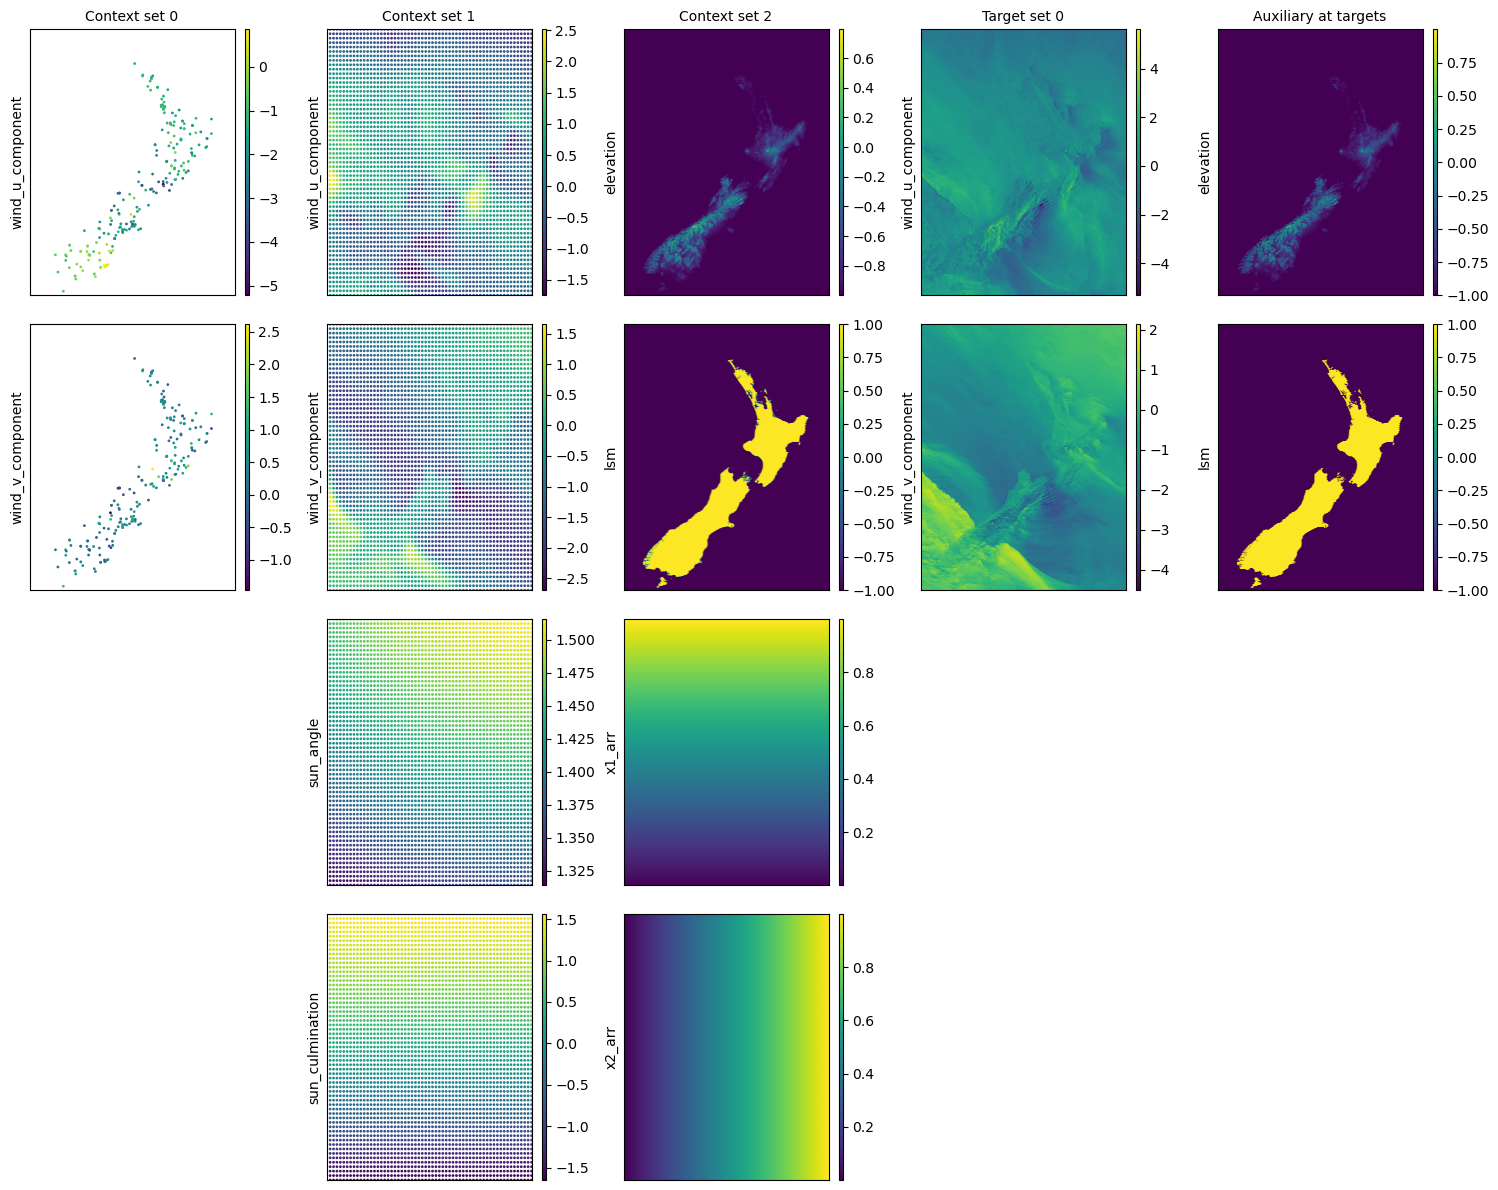

In [40]:
plot_task = deepsensor.plot.task(task_to_plot, norm_task_loader)
plot_task.show()

In [44]:
# save demo task to tensorboard
if not dev:
    tb_writer.add_figure(TB_EXAMPLE_TASK, plot_task.figure)
    tb_writer.flush()

## Model Training

In [ ]:
if not dev:
    tb_writer.add_hparams(
        {
            'initial_learning_rate': LR,
            'batch_size': BATCH_SIZE,
            'target_sampling_count': TARGET_SAMPLING_COUNT,
            'sampling_strategy': "all" if SAMPLING_STRATEGY == "all" else "repeated",
            'dev_mode': dev,
            'epochs': N_EPOCHS,
            'n_samples': len(train_datetimes),
            'unet': str(UNET_CHANNELS),
            'grad_clip': USE_GRAD_CLIP,
            'grad_clip_value': GRAD_CLIP_VALUE,
            'model_internal_density': INTERNAL_DENSITY,
            'model_receptive_field': model.model.receptive_field,
        },
        {}
    )

    tb_writer.add_text(TB_RUN_LOGS, f"Training started for {N_EPOCHS} epochs.", 3)
    tb_writer.flush()

In [47]:
if dataset_generation and not dev:
    logger.info("Exiting before model training.")
    tb_writer.add_text(TB_RUN_LOGS, "Exiting before model training.", 4)
    tb_writer.flush()
    
    os._exit(0)

logger.info("Model training starting.")

In [ ]:
# save the initial untrained model
if not dev:
    model_save_path = os.path.join(model_dir, "initial_model")
    torch.save(model.model.state_dict(), model_save_path + ".pt")

# training loop
opt = Adam(model.model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(opt, T_max=N_EPOCHS)
subsample_targets = None if SAMPLING_STRATEGY == "all" else TARGET_SAMPLING_COUNT

for epoch in range(N_EPOCHS):

    if epoch < UNFIX_NOISE_AT_EPOCH:
        noise_value = INITIAL_NOISE
    else:
        noise_value = None

    batch_losses = train_epoch_pickled(model, 
                                       train_dir, 
                                       opt, 
                                       batch_size=BATCH_SIZE, 
                                       epoch=epoch, 
                                       use_grad_clip=USE_GRAD_CLIP, 
                                       grad_clip_value=GRAD_CLIP_VALUE,
                                       grad_accum_steps=GRAD_ACCUM_STEPS,
                                       fix_noise=noise_value,
                                       n_subsample_targets=subsample_targets)
    
    train_loss = np.mean(batch_losses)

    scheduler.step()

    if not dev:
        tb_writer.add_scalar(TB_TRAIN_LOSS, train_loss, epoch+1)
        tb_writer.add_scalar(TB_CUDA_MEM, torch.cuda.max_memory_reserved()/1024**2, epoch+1)
        tb_writer.add_scalar(TB_LEARNING_RATE, opt.param_groups[0]['lr'], epoch+1)
        tb_writer.flush()
    
    if (epoch + 1) % CHECKPOINT_EVERY == 0:
        # checkpoint the model
        if not dev:
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}")
            torch.save(model.model.state_dict(), model_save_path + ".pt")

    if (epoch + 1) % VAL_EVERY == 0:

        with torch.no_grad():
            val_loss = compute_val_loss_pickled(model, val_dir, batch_size=BATCH_SIZE, epoch=epoch, fix_noise=noise_value, n_subsample_targets=subsample_targets)
            if not dev:
                tb_writer.add_scalar(TB_VAL_LOSS, val_loss, epoch+1)
                tb_writer.flush()

            logger.info(f"Epoch {epoch+1} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

            # do sample predictions and log to tensorboard
            
            # first, select a random validation task from the list of validaiton dates
            train_date = train_datetimes[np.random.randint(0, len(train_datetimes))]
            val_date = val_datetimes[np.random.randint(0, len(val_datetimes))]

            # tasks are created on-the-fly here for prediction
            era5_train_date_ds = era5_ds.sel(time=train_date)
            #h8_train_date_ds = h8_ds.sel(time=train_date)
            nzra_train_date_ds = nzra_ds.sel(time=train_date)
            stations_train_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == train_date]
            
            era5_val_date_ds = era5_ds.sel(time=val_date)
            #h8_val_date_ds = h8_ds.sel(time=val_date)
            nzra_val_date_ds = nzra_ds.sel(time=val_date)
            stations_val_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == val_date]
            
            # None in place of himawari8 dataset for now

            train_fig = return_sample_predictions(era5_train_date_ds, None, nzra_train_date_ds, nzra_ds, stations_train_date_df, ds_aux_processed, ds_aux_coarse_processed, train_date, data_processor, epoch+1, model, target=target_variable[0], subtitle_text=f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
            val_fig = return_sample_predictions(era5_val_date_ds, None, nzra_val_date_ds, nzra_ds, stations_val_date_df, ds_aux_processed, ds_aux_coarse_processed, val_date, data_processor, epoch+1, model, target=target_variable[0], subtitle_text=f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
            
            if not dev:
                tb_writer.add_figure(TB_PREDICTIONS_TRAIN_PLOT, train_fig, epoch+1)
                tb_writer.add_figure(TB_PREDICTIONS_VAL_PLOT, val_fig, epoch+1)
                tb_writer.flush()

  0%|          | 0/1746 [00:00<?, ?it/s]

Tasks: [time: ['Timestamp/2017-04-02 08:00:00', 'Timestamp/2017-05-15 15:00:00', 'Timestamp/2017-09-24 17:00:00', 'Timestamp/2017-09-30 04:00:00']
ops: ['str/batch_dim', 'str/float32', 'str/numpy_mask', 'str/nps_mask']
X_c: [('ndarray/float32/(4, 1, 556)', 'ndarray/float32/(4, 1, 556)'), 'ndarray/float32/(4, 2, 218)', ('ndarray/float32/(4, 1, 61)', 'ndarray/float32/(4, 1, 61)'), ('ndarray/float32/(4, 1, 556)', 'ndarray/float32/(4, 1, 556)')]
Y_c: ['Masked/(y=float32/(4, 3, 556, 556))/(mask=bool/(4, 1, 556, 556))', 'Masked/(y=float32/(4, 1, 218))/(mask=bool/(4, 1, 218))', 'Masked/(y=float32/(4, 8, 61, 61))/(mask=bool/(4, 1, 61, 61))', 'Masked/(y=float32/(4, 5, 556, 556))/(mask=bool/(4, 1, 556, 556))']
X_t: ['ndarray/float32/(4, 2, 1000)']
Y_t: ['ndarray/float32/(4, 1, 1000)']
Y_t_aux: ndarray/float32/(4, 3, 1000)
]
Task: time: [Timestamp('2017-04-02 08:00:00'), Timestamp('2017-05-15 15:00:00'), Timestamp('2017-09-24 17:00:00'), Timestamp('2017-09-30 04:00:00')]
ops: ['batch_dim', 'float

  0%|          | 0/1746 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 22, 5, 5], expected input[4, 21, 1344, 1344] to have 22 channels, but got 21 channels instead

In [ ]:
logger.info("Model training and notebook execution completed.")

if not dev:
    tb_writer.add_text(TB_RUN_LOGS, "Model training and notebook execution completed.", 4)
    tb_writer.flush()